# Import Libraries

In [1]:
import os
import requests
import pandas as pd
from requests.auth import HTTPBasicAuth
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score
from numpy import triu
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np
from collections import Counter
import itertools
import re
import time
import joblib

# Credentials (use OAuth or API token in real cases)

In [6]:
JIRA_EMAIL = 'your mailid'
JIRA_DOMAIN = 'your mailid Jira'
JIRA_API_TOKEN = 'Jira api token'
PROJECT_KEY = 'jira key'

In [8]:
### Construct API Call
search_url = f"https://{JIRA_DOMAIN}/rest/api/3/search"
headers = {"Accept": "application/json",
           "Content-Type": "application/json"}
auth = HTTPBasicAuth(JIRA_EMAIL, JIRA_API_TOKEN)

In [10]:
### To Use Pagination Parameters
start_at = 0
max_results = 100
total_issues = []
is_last = False

while not is_last:
    query = { 'jql' : f'project = "{PROJECT_KEY}"', 
              'maxResults' : 100 , 
              'fields' : 'key,summary,description,priority,created,duedate,status,assignee' 
    }
    
    ### Make API Call
    response = requests.get(search_url, headers=headers, params=query, auth=auth)
    
    # Parse Response
    if response.status_code != 200:
       raise Exception(f"Failed to fetch issues: {response.status_code} - {response.text}")
    
    data = response.json()
    issues = data.get('issues', [])
    total_issues.extend(issues)
    
    ### Pagination Logic
    start_at += max_results
    is_last = start_at >= data.get('total', 0)

print(f"Total Issues Fetched: {len(total_issues)}")


### Parse the Issues into a Dataframe
task_data = []
for issue in total_issues:
    fields = issue['fields']
    task_data.append({
        'task_id': issue['key'],
        'title': fields.get('summary', ''),
        'description': fields.get('description', ''),
        'priority': fields.get('priority', {}).get('name', ''),
        'created_at': fields.get('created', ''),
        'status': fields.get('status', {}).get('name', ''),
        'assigned_to': fields.get('assignee', {}).get('displayName', ''),
        'due_date': fields.get('duedate', '')
    })

df_jira = pd.DataFrame(task_data)

Total Issues Fetched: 3


In [12]:
df_jira

,task_id,title,description,priority,created_at,status,assigned_to,due_date
0,TMSP123-6,Sample issue for testing,"{'type': 'doc', 'version': 1, 'content': [{'ty...",Medium,2025-05-19T12:43:57.610+0530,To Do,Vasandharaja S,None
1,TMSP123-5,Sample issue for testing,"{'type': 'doc', 'version': 1, 'content': [{'ty...",Medium,2025-05-18T13:33:31.223+0530,To Do,Vasandharaja S,None
2,TMSP123-4,TMSP123,None,Medium,2025-05-18T13:31:01.746+0530,In Progress,Vasandharaja S,None


In [14]:
# Pagination of Apache Hadoop Fetch Issues
search_url = "https://issues.apache.org/jira/rest/api/2/search"
start_at = 0
max_results = 100
total_issues = []
is_last = False

while not is_last:
    query = {
        'jql': 'project = HADOOP',
        'startAt': start_at,
        'maxResults': max_results,
        'fields': 'key,summary,description,priority,created,status'
    }

    response = requests.get(search_url, params=query)
    if response.status_code != 200:
        raise Exception(f"Failed: {response.status_code} - {response.text}")

    data = response.json()
    issues = data.get('issues', [])
    total_issues.extend(issues)
    
    start_at += max_results
    is_last = start_at >= data.get('total', 0)
    time.sleep(0.5)

# Convert to DataFrame
task_data = []
for issue in total_issues:
    fields = issue['fields']
    task_data.append({
        'task_id': issue['key'],
        'title': fields.get('summary', ''),
        'description': fields.get('description', ''),
        'priority': fields.get('priority', {}).get('name', ''),
        'created_at': fields.get('created', ''),
        'status': fields.get('status', {}).get('name', '')
    })

df_Hadoop = pd.DataFrame(task_data)
df_Hadoop.to_csv("apache_hadoop_issues.csv", index=False)
print(f"Fetched {len(df_Hadoop)} Hadoop issues.")

Fetched 17263 Hadoop issues.


In [15]:
#### To show the DataFrame after collecting the Apache Hadoop JIRA issues
df_Hadoop = pd.read_csv("apache_hadoop_issues.csv")
print(f"Total Issues: {df_Hadoop.shape[0]}")
df_Hadoop.head()

Total Issues: 17263


,task_id,title,description,priority,created_at,status
0,HADOOP-19579,Update the command usage of NNThroughputBenchm...,"In HDFS-15652, make block size from NNThroughp...",Major,2025-05-26T07:50:02.000+0000,Open
1,HADOOP-19578,Upgrade com.huaweicloud:esdk-obs-java for CVE-...,The {{com.huaweicloud:esdk-obs-java}} dependen...,Major,2025-05-25T08:19:54.000+0000,Open
2,HADOOP-19577,Improve error message when the path contains d...,"Currently, we display the following error mess...",Minor,2025-05-23T05:58:18.000+0000,Open
3,HADOOP-19576,Insert Overwrite Jobs With MagicCommitter Fail...,Query engines which uses Magic Committer to ov...,Major,2025-05-22T10:18:50.000+0000,Open
4,HADOOP-19575,ABFS: [FNSOverBlob] Add Distinct String In Use...,Add a unique identifier in FNS-Blob user agent...,Major,2025-05-22T06:45:27.000+0000,Open


In [16]:
### Drop Null and Duplicates
df_Hadoop.dropna(subset=["title", "priority"], inplace=True)
df_Hadoop.drop_duplicates(inplace=True)

In [17]:
###  Map the High Medium Low
def map_priority(p):
    p = str(p).lower()
    if p in ["blocker", "critical"]:
        return "High"
    elif p == "major":
        return "Medium"
    else:
        return "Low"

df_Hadoop["priority_level"] = df_Hadoop["priority"].apply(map_priority)
df_Hadoop["priority_level"].value_counts()

priority_level
Medium    11141
Low        4325
High       1797
Name: count, dtype: int64

# Perform Clean Data

In [19]:
### To Clean The Data
# Clean the Hadoop issues DataFrame
df_Hadoop['created_at'] = pd.to_datetime(df_Hadoop['created_at'])            
df_Hadoop['description'] = df_Hadoop['description'].fillna('')                  
df_Hadoop['status'] = df_Hadoop['status'].str.lower().str.strip()              
df_Hadoop['priority'] = df_Hadoop['priority'].str.strip().str.title()          

# Show data types and preview
print(df_Hadoop.dtypes)
print(df_Hadoop.head())

task_id                        object
title                          object
description                    object
priority                       object
created_at        datetime64[ns, UTC]
status                         object
priority_level                 object
dtype: object
        task_id                                              title  \
0  HADOOP-19579  Update the command usage of NNThroughputBenchm...   
1  HADOOP-19578  Upgrade com.huaweicloud:esdk-obs-java for CVE-...   
2  HADOOP-19577  Improve error message when the path contains d...   
3  HADOOP-19576  Insert Overwrite Jobs With MagicCommitter Fail...   
4  HADOOP-19575  ABFS: [FNSOverBlob] Add Distinct String In Use...   

                                         description priority  \
0  In HDFS-15652, make block size from NNThroughp...    Major   
1  The {{com.huaweicloud:esdk-obs-java}} dependen...    Major   
2  Currently, we display the following error mess...    Minor   
3  Query engines which uses Magic Commi

# Apply NLP Preprocessing on Task Description(Stemming, Tokenizing & Stopword Removal

In [21]:
import spacy
nlp = spacy.load("en_core_web_sm")

# Cleaning function
def clean_text(text):
    if not isinstance(text, str): return ""
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if token.is_alpha and not token.is_stop])

# Apply cleaning to title and description
df_Hadoop["clean_title"] = df_Hadoop["title"].apply(clean_text)
df_Hadoop["clean_description"] = df_Hadoop["description"].fillna("").apply(clean_text)

# Preview cleaned dataset
df_Hadoop_cleaned_preview = df_Hadoop[["title", "clean_title", "description", "clean_description", "priority", "priority_level"]]
df_Hadoop_cleaned_preview.head(10)

,title,clean_title,description,clean_description,priority,priority_level
0,Update the command usage of NNThroughputBenchm...,update command usage NNThroughputBenchmark add...,"In HDFS-15652, make block size from NNThroughp...",block size NNThroughputBenchmark configurable ...,Major,Medium
1,Upgrade com.huaweicloud:esdk-obs-java for CVE-...,Upgrade esdk obs java,The {{com.huaweicloud:esdk-obs-java}} dependen...,esdk obs java dependency exclusively hadoop hu...,Major,Medium
2,Improve error message when the path contains d...,improve error message path contain double slas...,"Currently, we display the following error mess...",currently display follow error message path co...,Minor,Low
3,Insert Overwrite Jobs With MagicCommitter Fail...,Insert Overwrite Jobs MagicCommitter fail Expr...,Query engines which uses Magic Committer to ov...,query engine use Magic Committer overwrite dir...,Major,Medium
4,ABFS: [FNSOverBlob] Add Distinct String In Use...,abfs fnsoverblob add distinct string User Agen...,Add a unique identifier in FNS-Blob user agent...,add unique identifier FNS Blob user agent usag...,Major,Medium
5,Restore Subject propagation semantics for Java...,restore subject propagation semantic Java,Java 22 breaks Subject propagation for new Thr...,java break subject propagation new thread Secu...,Critical,High
6,S3A: ITestS3AConfiguration.testDirectoryAlloca...,fail,while working on HADOOP-19554 I added a per-bu...,work add bucket setting fail test run entire c...,Minor,Low
7,ABFS: [FnsOverBlob] Empty Page Issue on Subseq...,abfs fnsoverblob Page issue Subsequent ListBlob,We came across a new behavior from server wher...,come new behavior server ListBlob return list ...,Major,Medium
8,Improve PrometheusMetricsSink#normalizeName pe...,improve performance,This patch is similar from HDDS-13014. We can ...,patch similar add normalization cache Hadoop m...,Major,Medium
9,Upgrade libxxhash to 0.8.3 in Windows 10,Upgrade libxxhash Windows,The current version of libxxhash - 0.8.1 isn't...,current version libxxhash available msys repo ...,Major,Medium


In [22]:
# Function to lemmatize and return list of tokens
def lemmatize_tokens(text):
    if not isinstance(text, str):
        return []
    doc = nlp(text)
    return [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

In [23]:
# Apply lemmatization
df_Hadoop["title_tokens"] = df_Hadoop["title"].apply(lemmatize_tokens)
df_Hadoop["description_tokens"] = df_Hadoop["description"].fillna("").apply(lemmatize_tokens)

In [24]:
# Combine tokens into input text
df_Hadoop["input_text"] = df_Hadoop["title_tokens"].apply(lambda x: " ".join(x)) + " " + \
                          df_Hadoop["description_tokens"].apply(lambda x: " ".join(x))

In [25]:
# Final DataFrame
df_final = df_Hadoop[["input_text", "priority_level"]]

In [26]:
df_final.head(5)

,input_text,priority_level
0,update command usage NNThroughputBenchmark add...,Medium
1,Upgrade esdk obs java esdk obs java dependency...,Medium
2,improve error message path contain double slas...,Low
3,Insert Overwrite Jobs MagicCommitter fail Expr...,Medium
4,abfs fnsoverblob add distinct string User Agen...,Medium


In [27]:
# Save cleaned data
df_final.to_csv("models/jira_issues_cleaned.csv", index=False)
print("Cleaned data saved to models/jira_issues_cleaned.csv")

Cleaned data saved to models/jira_issues_cleaned.csv


In [28]:
df_final.head(10)

,input_text,priority_level
0,update command usage NNThroughputBenchmark add...,Medium
1,Upgrade esdk obs java esdk obs java dependency...,Medium
2,improve error message path contain double slas...,Low
3,Insert Overwrite Jobs MagicCommitter fail Expr...,Medium
4,abfs fnsoverblob add distinct string User Agen...,Medium
5,restore subject propagation semantic Java java...,High
6,fail work add bucket setting fail test run ent...,Low
7,abfs fnsoverblob Page issue Subsequent ListBlo...,Medium
8,improve performance patch similar add normaliz...,Medium
9,Upgrade libxxhash Windows current version libx...,Medium


In [29]:
# Basic data overview
print(df_final.info())
print(df_final.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17263 entries, 0 to 17262
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   input_text      17263 non-null  object
 1   priority_level  17263 non-null  object
dtypes: object(2)
memory usage: 269.9+ KB
None
                                               input_text priority_level
count                                               17263          17263
unique                                              17170              3
top     building error run mvn clean install get error...         Medium
freq                                                   12          11141


### Perform exploratory data analysis (EDA)

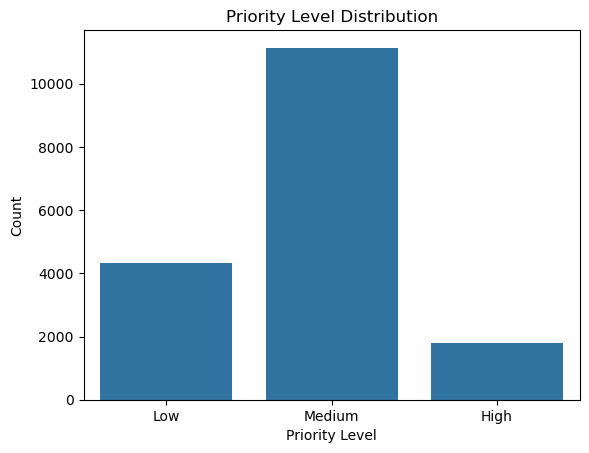

In [36]:
# 1.Class distribution
sns.countplot(data=df_final, x='priority_level', order=['Low', 'Medium', 'High'])
plt.title("Priority Level Distribution")
plt.xlabel("Priority Level")
plt.ylabel("Count")
plt.show()

C:\Users\anand\AppData\Local\Temp\ipykernel_4316\2186902116.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['char_count'] = df_final['input_text'].apply(len)
C:\Users\anand\AppData\Local\Temp\ipykernel_4316\2186902116.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['word_count'] = df_final['input_text'].apply(lambda x: len(x.split()))


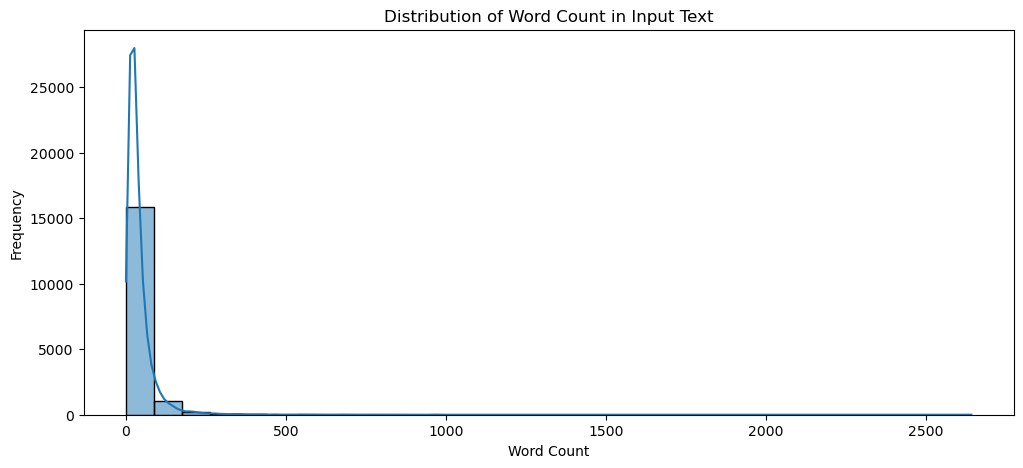

In [37]:
### 2.Length of Text (Tokens & Characters)
# Add text length features
df_final['char_count'] = df_final['input_text'].apply(len)
df_final['word_count'] = df_final['input_text'].apply(lambda x: len(x.split()))

# Distribution plots
plt.figure(figsize=(12,5))
sns.histplot(df_final['word_count'], bins=30, kde=True)
plt.title("Distribution of Word Count in Input Text")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

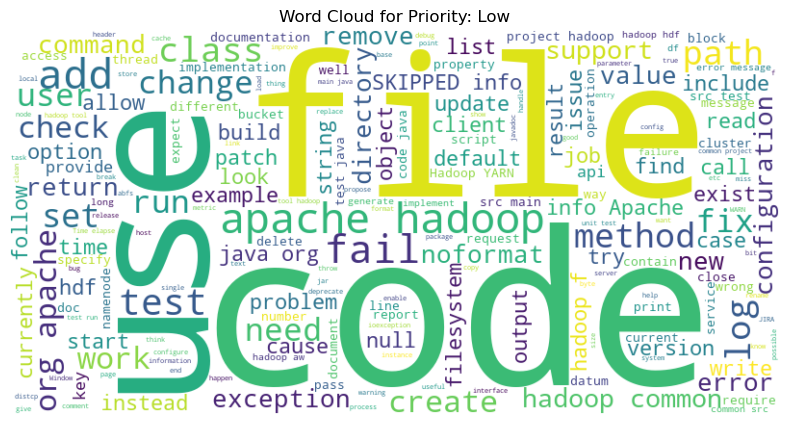

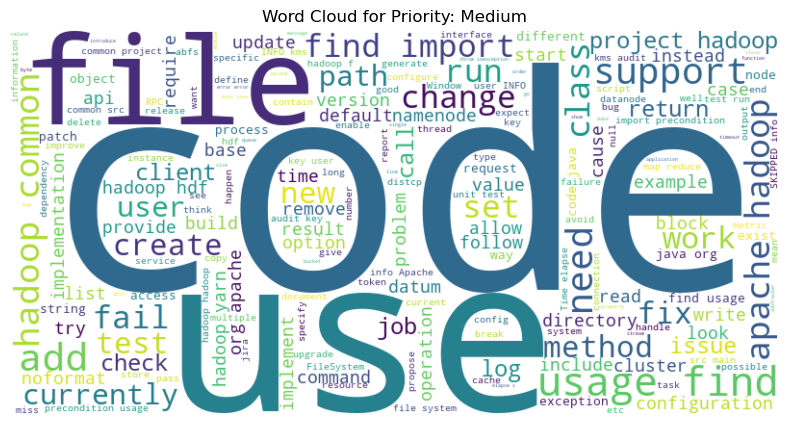

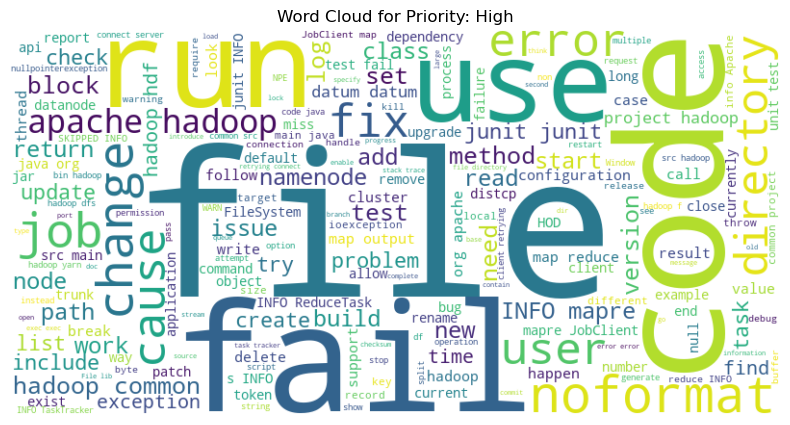

In [38]:
### 3.Word Cloud for Each Priority Level
from wordcloud import WordCloud

for level in ['Low', 'Medium', 'High']:
    text = " ".join(df_final[df_final["priority_level"] == level]["input_text"])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Priority: {level}")
    plt.show()

In [39]:
###  4.Top Frequent Words
# Flatten all words from all input_text
all_words = list(itertools.chain.from_iterable(df_final["input_text"].apply(lambda x: x.split())))
word_freq = Counter(all_words)

# Show most common
print("Top 20 frequent words:", word_freq.most_common(20))

Top 20 frequent words: [('hadoop', 13375), ('file', 8619), ('code', 8157), ('test', 7334), ('error', 5500), ('fail', 5304), ('use', 4412), ('run', 4264), ('add', 4167), ('find', 4049), ('Hadoop', 3756), ('user', 3674), ('INFO', 3319), ('class', 3146), ('new', 3112), ('common', 2988), ('need', 2974), ('job', 2945), ('create', 2930), ('info', 2839)]


# Feature extraction using TF-IDF/word embeddings (Word2Vec/BERT)

# 1. TF-IDF Feature Extraction

In [42]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df_final["input_text"])
y = df_final["priority_level"]

# 2. Word2Vec Feature Extraction

In [44]:
# Tokenize input text
df_final["tokens"] = df_final["input_text"].apply(word_tokenize)

# Train Word2Vec model
w2v_model = Word2Vec(sentences=df_final["tokens"], vector_size=100, window=5, min_count=2, workers=4)

# Convert sentence to averaged Word2Vec vector
def get_w2v_vector(tokens):
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

X_w2v = np.vstack(df_final["tokens"].apply(get_w2v_vector))

C:\Users\anand\AppData\Local\Temp\ipykernel_4316\4011101585.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["tokens"] = df_final["input_text"].apply(word_tokenize)


In [45]:
X_w2v

array([[-0.26339465,  0.07880355, -0.3981148 , ..., -0.29515526,
         0.58287704, -0.08403294],
       [-0.29503149, -0.15123323, -0.09974134, ..., -0.16284467,
         0.48632354,  0.50813299],
       [-0.21943198,  0.22484373, -0.12867033, ..., -0.01932228,
         0.04455193, -0.1220549 ],
       ...,
       [-0.24506682,  0.15629499,  0.16751862, ..., -0.55125666,
         0.87986952,  0.07478478],
       [-0.41388091, -0.09069651, -0.23901935, ..., -0.39274415,
        -0.05858514, -0.11952864],
       [ 0.10969307,  0.1975863 , -0.02556079, ..., -0.09360403,
         0.51604778, -0.06567097]])

# 3. BERT Embeddings (with SentenceTransformers)

In [47]:
model = SentenceTransformer('all-MiniLM-L6-v2')
X_bert = model.encode(df_final["input_text"], show_progress_bar=False)

In [48]:
X_bert

array([[-0.03747207,  0.01173617, -0.05992259, ..., -0.04985188,
         0.03056894,  0.00174365],
       [-0.06444   ,  0.07724024,  0.08176181, ..., -0.01068722,
         0.09230251, -0.00412459],
       [-0.01347232,  0.0344478 ,  0.0673184 , ...,  0.05571486,
        -0.01343653, -0.04479024],
       ...,
       [ 0.01035016,  0.07255279,  0.03046157, ...,  0.08003338,
         0.01655019, -0.01221696],
       [ 0.07869458, -0.00247337,  0.0425039 , ..., -0.07413522,
        -0.09417916,  0.00604921],
       [-0.06325772, -0.04781933, -0.01344174, ...,  0.01664517,
        -0.03621833, -0.05442462]], dtype=float32)

# 4.Implement task classification using Naive Bayes and SVM

In [50]:
### Task Classification
# Inputs and target
X_text = df_final['input_text']
y = df_final['priority_level'] 

In [54]:
### Naive Bayes (TF-IDF only)
# Split TF-IDF data
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Train model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Predict
y_pred_nb = nb_model.predict(X_test_tfidf)

# Print classification report
print("Naive Bayes (TF-IDF) Results:\n", classification_report(y_test, y_pred_nb))

Naive Bayes (TF-IDF) Results:
               precision    recall  f1-score   support

        High       1.00      0.01      0.01       360
         Low       0.55      0.05      0.09       839
      Medium       0.66      0.99      0.79      2254

    accuracy                           0.66      3453
   macro avg       0.74      0.35      0.30      3453
weighted avg       0.67      0.66      0.54      3453



In [62]:
### SVM (Support Vector Machine) Using BERT-Model 
# Split BERT embeddings
X_train_bert, X_test_bert, y_train, y_test = train_test_split(X_bert, y, test_size=0.2, random_state=42)

# Train model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_bert, y_train)

# Predict
y_pred_svm = svm_model.predict(X_test_bert)
print("SVM (BERT) Results:\n", classification_report(y_test, y_pred_svm))

SVM (BERT) Results:
               precision    recall  f1-score   support

        High       0.00      0.00      0.00       360
         Low       0.00      0.00      0.00       839
      Medium       0.65      1.00      0.79      2254

    accuracy                           0.65      3453
   macro avg       0.22      0.33      0.26      3453
weighted avg       0.43      0.65      0.52      3453



C:\Users\anand\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\anand\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\anand\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [63]:
### Evaluate using accuracy, precision, recall
def evaluate_model(name, y_true, y_pred):
    print(f"\n=== Evaluation for {name} ===")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='weighted'))
    print("Recall   :", recall_score(y_true, y_pred, average='weighted'))

In [64]:
### Run Evaluations
evaluate_model("Naive Bayes (TF-IDF)", y_test, y_pred_nb)
evaluate_model("SVM (BERT)", y_test, y_pred_svm)

C:\Users\anand\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Evaluation for Naive Bayes (TF-IDF) ===
Accuracy : 0.6562409498986389
Precision: 0.6680289942541693
Recall   : 0.6562409498986389

=== Evaluation for SVM (BERT) ===
Accuracy : 0.6527657109759629
Precision: 0.4261030734259544
Recall   : 0.6527657109759629


In [70]:
# Create a directory for models
os.makedirs("models", exist_ok=True)

# Save TF-IDF vectorizer
joblib.dump(vectorizer, "models/tfidf_vectorizer.pkl")
print("✔ TF-IDF vectorizer saved to models/tfidf_vectorizer.pkl")

# Save Naive Bayes model
joblib.dump(nb_model, "models/nb_tfidf_model.pkl")
print("✔ Naive Bayes model saved to models/nb_tfidf_model.pkl")

# Save SVM model trained on BERT embeddings
joblib.dump(svm_model, "models/svm_bert_model.pkl")
print("✔ SVM (BERT) model saved to models/svm_bert_model.pkl")

# Save BERT test data
joblib.dump(X_test_bert, "models/X_test_bert.pkl")
joblib.dump(y_test, "models/y_test_bert.pkl")  # <-- fixed
print("✔ BERT test data saved to models/X_test_bert.pkl and models/y_test_bert.pkl")

# Save cleaned CSVs
df_Hadoop_cleaned_preview.to_csv("models/apache_hadoop_issues.csv", index=False)
df_jira.to_csv("models/jira_issues_lemmatized.csv", index=False)
print("✔ CSV files saved to models folder")

✔ TF-IDF vectorizer saved to models/tfidf_vectorizer.pkl
✔ Naive Bayes model saved to models/nb_tfidf_model.pkl
✔ SVM (BERT) model saved to models/svm_bert_model.pkl
✔ BERT test data saved to models/X_test_bert.pkl and models/y_test_bert.pkl
✔ CSV files saved to models folder


In [121]:
#  Save cleaned dataframe if you haven't already
# Load the lemmatized CSV file you saved earlier
df = pd.read_csv("models/jira_issues_lemmatized.csv")

# Use 'description' as text data, and 'priority' as labels
text_data = df["description"]
labels = df["priority"]

# Load the trained TF-IDF vectorizer
tfidf_vectorizer = joblib.load("models/tfidf_vectorizer.pkl")

# Split into train/test sets (you might only need test split here)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    text_data, labels, test_size=0.2, random_state=42
)

# Transform test data using the TF-IDF vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test_raw)

# Create models directory if not exist
os.makedirs("models", exist_ok=True)

# Save the transformed test data and labels
joblib.dump(X_test_tfidf, "models/X_test_tfidf.pkl")
joblib.dump(y_test, "models/y_test.pkl")

print("✅ TF-IDF test data saved successfully to models/X_test_tfidf.pkl and y_test.pkl")

✅ TF-IDF test data saved successfully to models/X_test_tfidf.pkl and y_test.pkl


In [72]:
### Load models and vectorizer
vectorizer = joblib.load("models/tfidf_vectorizer.pkl")
nb_model = joblib.load("models/nb_tfidf_model.pkl")
svm_model = joblib.load("models/svm_bert_model.pkl")

# Load BERT test data
X_test_bert = joblib.load("models/X_test_bert.pkl")
y_test_bert = joblib.load("models/y_test_bert.pkl")

# Load BERT model
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Sample new text
new_text = ["This task is high priority and needs urgent attention"]

# === Predict with Naive Bayes (TF-IDF) ===
X_new_tfidf = vectorizer.transform(new_text)
pred_nb = nb_model.predict(X_new_tfidf)

# === Predict with SVM (BERT) ===
X_new_bert = bert_model.encode(new_text)
pred_svm = svm_model.predict(X_new_bert)

print("Naive Bayes Prediction:", pred_nb[0])
print("SVM (BERT) Prediction:", pred_svm[0])
print("✔ Models loaded and predictions completed.")

Naive Bayes Prediction: Medium
SVM (BERT) Prediction: Medium
✔ Models loaded and predictions completed.


# Implement priority prediction model using Random Forest/XGBoost

In [75]:
df = pd.read_csv("models/jira_issues_cleaned.csv")
print(df.columns)

Index(['input_text', 'priority_level'], dtype='object')


In [77]:
# Load data
df = pd.read_csv('models/jira_issues_cleaned.csv')
X = df['input_text'].astype(str)
y = df['priority_level']

In [79]:
# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(X)

In [80]:
# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, stratify=y, random_state=42
)

In [83]:
### Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_bert, y_train)
y_pred_rf = rf_model.predict(X_test_bert)
print("Random Forest classification report:")
print(classification_report(y_test, y_pred_rf))

Random Forest classification report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00       359
         Low       0.17      0.00      0.00       865
      Medium       0.65      1.00      0.78      2229

    accuracy                           0.64      3453
   macro avg       0.27      0.33      0.26      3453
weighted avg       0.46      0.64      0.51      3453



In [84]:
### Train XGBoost Classifier
# Encode string labels into numeric
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # 'High', 'Medium', 'Low' → 0,1,2

# Train-test split with encoded labels
X_train_bert, X_test_bert, y_train, y_test = train_test_split(
    X_tfidf, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

### Train XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_bert, y_train)
y_pred_xgb = xgb_model.predict(X_test_bert)
print("XGBoost classification report:")
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))

C:\Users\anand\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:23:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost classification report:
              precision    recall  f1-score   support

        High       0.44      0.05      0.09       359
         Low       0.58      0.17      0.26       865
      Medium       0.67      0.95      0.78      2229

    accuracy                           0.66      3453
   macro avg       0.56      0.39      0.38      3453
weighted avg       0.62      0.66      0.58      3453



# Apply GridSearchCV (Random Forest)

In [86]:
# Ramdom Forest GridSearch
# Random Forest Parameter Grid
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}

# GridSearchCV setup
grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Fit the model
grid_rf.fit(X_train_bert, y_train)

# Output the best parameters
print("Best RF Parameters:", grid_rf.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best RF Parameters: {'max_depth': None, 'n_estimators': 200}


In [101]:
#  GridSearchCV for XGBoost
# XGBoost parameter grid
import warnings
import joblib
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Define XGBoost Classifier
xgb_model = XGBClassifier(
    objective='multi:softprob', 
    eval_metric='mlogloss', 
    use_label_encoder=False,
    tree_method='auto',
    random_state=42
)

# Parameter Grid for Tuning
param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.2]
}

# Grid Search
grid_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Train with GridSearchCV
grid_xgb.fit(X_train_bert, y_train)

# Output best parameters
print("✅ Best Parameters for XGBoost:", grid_xgb.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
✅ Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}


In [103]:
### Evaluate All Models
def evaluate(name, y_true, y_pred):
    print(f"\n--- Evaluation for {name} ---")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='weighted'))
    print("Recall   :", recall_score(y_true, y_pred, average='weighted'))
    print("Report:\n", classification_report(y_true, y_pred, target_names=le.classes_))

# Evaluate Both Models
evaluate("Best Random Forest", y_test, grid_rf.predict(X_test_bert))
evaluate("Best XGBoost", y_test, grid_xgb.predict(X_test_bert))


--- Evaluation for Best Random Forest ---
Accuracy : 0.6562409498986389
Precision: 0.6217927383169872
Recall   : 0.6562409498986389
Report:
               precision    recall  f1-score   support

        High       0.45      0.01      0.03       359
         Low       0.59      0.11      0.19       865
      Medium       0.66      0.97      0.79      2229

    accuracy                           0.66      3453
   macro avg       0.57      0.37      0.33      3453
weighted avg       0.62      0.66      0.56      3453


--- Evaluation for Best XGBoost ---
Accuracy : 0.6576889661164205
Precision: 0.6466863439162552
Recall   : 0.6576889661164205
Report:
               precision    recall  f1-score   support

        High       0.62      0.02      0.04       359
         Low       0.63      0.09      0.16       865
      Medium       0.66      0.98      0.79      2229

    accuracy                           0.66      3453
   macro avg       0.63      0.36      0.33      3453
weighted avg   

In [105]:
### Save the Best Performing Model
# Ensure models directory exists
import os
import joblib

# Ensure directory exists
os.makedirs("models", exist_ok=True)

# Save best estimators from GridSearchCV
joblib.dump(grid_rf.best_estimator_, "models/best_random_forest_model.pkl")
joblib.dump(grid_xgb.best_estimator_, "models/best_xgboost_model.pkl")

# Save label encoder
joblib.dump(le, "models/label_encoder.pkl")

# Save TF-IDF vectorizer used for BERT or input text
joblib.dump(tfidf, "models/tfidf_vectorizer.pkl")

print("✅ All models and preprocessors saved successfully!")

✅ All models and preprocessors saved successfully!


In [107]:
# Load models
rf_model = joblib.load("models/best_random_forest_model.pkl")
xgb_model = joblib.load("models/best_xgboost_model.pkl")
le = joblib.load("models/label_encoder.pkl")
tfidf = joblib.load("models/tfidf_vectorizer.pkl")

In [109]:
# Save final models
joblib.dump(grid_rf.best_estimator_, "models/final_rf_model.pkl")
joblib.dump(grid_xgb.best_estimator_, "models/final_xgb_model.pkl")

# Save preprocessors
joblib.dump(le, "models/label_encoder.pkl")
joblib.dump(tfidf, "models/tfidf_vectorizer.pkl")

['models/tfidf_vectorizer.pkl']